# Squashy Subreddit Demo


In [1]:
# Demo dependencies

! pip install netwulf
! pip install wordcloud


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# Connect to Memgraph instance
from mini_memgraph import Memgraph

# Connect to instance
db = Memgraph(address='localhost', port=7687)


# WARNING!
This will replace all data in your memgraph instance. Please ensure you are using a new instance of Memgraph before proceeding.

# Loading the Data
The dataset is the Subreddit Hyperlink Network (body) available from [SNAP](https://snap.stanford.edu/data/soc-RedditHyperlinks.html).

Download the dataset from [SNAP](https://snap.stanford.edu/data/soc-RedditHyperlinks.html) and drop the .tsv into the same folder as this notebook.

```
@inproceedings{kumar2018community,
  title={Community interaction and conflict on the web},
  author={Kumar, Srijan and Hamilton, William L and Leskovec, Jure and Jurafsky, Dan},
  booktitle={Proceedings of the 2018 World Wide Web Conference on World Wide Web},
  pages={933--943},
  year={2018},
  organization={International World Wide Web Conferences Steering Committee}
}
```

In [7]:
data_path = 'soc-redditHyperlinks-body.tsv'

In [8]:
import pandas as pd
# Wipe existing data ready for import
db.write('MATCH (n) DETACH DELETE n')

# Set indexes
db.set_index('SUBREDDIT')
db.set_index('SUBREDDIT','id')
db.set_constraint('SUBREDDIT','id')

# Write all unique subreddit nodes
nodes = set()
with pd.read_csv(data_path, usecols=['SOURCE_SUBREDDIT','TARGET_SUBREDDIT'], sep='\t', chunksize=10000) as reader:
    for chunk in reader:
        nodes.update(chunk['SOURCE_SUBREDDIT'].tolist())
        nodes.update(chunk['TARGET_SUBREDDIT'].tolist())

node_list = [{'id':node} for node in list(nodes)]
db.write_nodes(node_list,id_val='id',label='SUBREDDIT')

# Write subreddit to subreddit link relations
# Edge frequencies are incremented for all duplicates found and saved as a 'weight' attribute
rename_cols = {'SOURCE_SUBREDDIT':'source','TARGET_SUBREDDIT':'target'}
with pd.read_csv(data_path,usecols=['SOURCE_SUBREDDIT','TARGET_SUBREDDIT'], sep='\t', chunksize=10000) as reader:
    for chunk in reader:
        edge_list = chunk.rename(columns=rename_cols).to_dict(orient='records')
        db.write_edges(edge_list,edge_label='LINKS_TO', source_label='SUBREDDIT',target_label='SUBREDDIT',
                      on_duplicate_edges='increment')


# Squash Graph!

In [1]:
from squashy import Squash

squasher = Squash(node_label='SUBREDDIT',relation_label='LINKS_TO', weight_label='weight')
squasher.reset()
squasher.squash(max_hops=2)

cores_identified:0 | graph_size:35,776 | n_remaining:35,776 | min_degree:1 | max_degree:2,524 | pass_:0 | loca…

  0%|          | 0/1000 [00:00<?, ?it/s]

# Identify Core Nodes

In [2]:
squasher.meta_relator.count_meta_relations()

39164

In [3]:
squasher.meta_relator.cutoff_score

5.653846153846153

In [6]:
squasher.meta_relator.score_ecdf()

# Examine Squashed Graph

In [7]:
edges = squasher.get_core_edge_list()
nodes = squasher.get_core_node_list()

In [8]:
n_squashed_nodes = len(nodes)
n_squashed_edges = len(edges)

In [10]:
n_raw_nodes = squasher.db.node_count('SUBREDDIT')

In [12]:
n_raw_edges = squasher.db.read('MATCH ()-[r:LINKS_TO]-() RETURN count(r) AS n_edges')[0]['n_edges']

In [13]:
print(f"Original Graph size: {n_raw_nodes:,} Nodes and {n_raw_edges:,} Edges")
print(f"Squashed Graph size: {n_squashed_nodes:,} Nodes and {n_squashed_edges:,} Edges")
print(f"Squashed Graph is {(n_squashed_nodes/n_raw_nodes)*100:.2}% of the original nodes & {(n_squashed_edges/n_raw_edges)*100:.2}% of the original edges ")


Original Graph size: 35,776 Nodes and 275,642 Edges
Squashed Graph size: 342 Nodes and 628 Edges
Squashed Graph is 0.96% of the original nodes & 0.23% of the original edges 


## Detect Communities

In [14]:
import networkx as nx
import pandas as pd
edge_list = pd.DataFrame(edges)
node_list = pd.DataFrame(nodes)

In [15]:
edge_list.head()

,source,target,weight,n_distinct,score
0,nba,bostonceltics,90,54,34.225352
1,mushroomkingdom,badkarma,74,22,37.860465
2,nfl,chargers,163,20,26.290323
3,oppression,news,12,6,8.000000
4,shitstatistssay,news,11,3,8.250000


In [16]:
node_list.head()

,id,n_subnodes
0,nba,142
1,askreddit,1667
2,nofap,80
3,mushroomkingdom,43
4,subredditdrama,1199


In [17]:
G = nx.from_pandas_edgelist(edge_list,edge_attr=True, create_using=nx.DiGraph)

node_attr = node_list.set_index('id').rename(columns={'n_subnodes':'size'}).to_dict(orient='index')
nx.set_node_attributes(G, node_attr)

In [18]:
G.number_of_nodes()

342

In [19]:
G.number_of_edges()

628

In [20]:
components = nx.components.connected_components(G.to_undirected())
giant_component = sorted(components, key=len, reverse=True)[0]
len(giant_component)

G = nx.subgraph(G,giant_component)

In [23]:
RESOLUTION = 0.8

communities = nx.algorithms.community.louvain_communities(G,weight='score', resolution=RESOLUTION)
modularity_score = nx.algorithms.community.modularity(G,communities,weight='score', resolution=RESOLUTION)


print(f"N Communities: {len(communities)} - Modularity: {modularity_score:.3}")

N Communities: 51 - Modularity: 0.664


In [24]:
com_to_assign = {}
for i, community in enumerate(communities):
    for member in community:
        com_to_assign[member] = i
com_to_assign

{'nba': 0,
 'bostonceltics': 0,
 'patriots': 1,
 'minnesotavikings': 1,
 '49ers': 1,
 'browns': 1,
 'redskins': 1,
 'nfl': 1,
 'fantasyfootball': 1,
 'greenbaypackers': 1,
 'detroitlions': 1,
 'nygiants': 1,
 'denverbroncos': 1,
 'eagles': 1,
 'chargers': 1,
 'steelers': 1,
 'buffalobills': 1,
 'seahawks': 1,
 'panthers': 1,
 'worldnews': 2,
 'shitamericanssay': 2,
 'israel': 2,
 'europe': 2,
 'pakistan': 2,
 'shitstatistssay': 3,
 'anarcho_capitalism': 3,
 'socialism': 3,
 'shitliberalssay': 3,
 'anarchism': 3,
 'profanitywatch': 4,
 'jokes': 4,
 'hailcorporate': 4,
 'askreddit': 4,
 'self': 4,
 'glitch_in_the_matrix': 4,
 'todayilearned': 4,
 'testingground4bots': 4,
 'mbti': 4,
 'explainlikeimfive': 4,
 'depression': 4,
 'findareddit': 4,
 'argentina': 4,
 'fantheories': 4,
 'volunteer': 4,
 'tifu': 4,
 'cooking': 4,
 'suicidewatch': 4,
 'movies': 4,
 'subredditoftheday': 4,
 'asktransgender': 4,
 'dailydot': 4,
 'pics': 4,
 'twoxchromosomes': 4,
 'television': 4,
 'theydidthemath':

In [25]:
sizes = node_list.set_index('id')['n_subnodes'].to_dict()

In [26]:
nx.set_node_attributes(G,sizes,'size')
nx.set_node_attributes(G,com_to_assign,'group')

In [27]:
import netwulf as nw

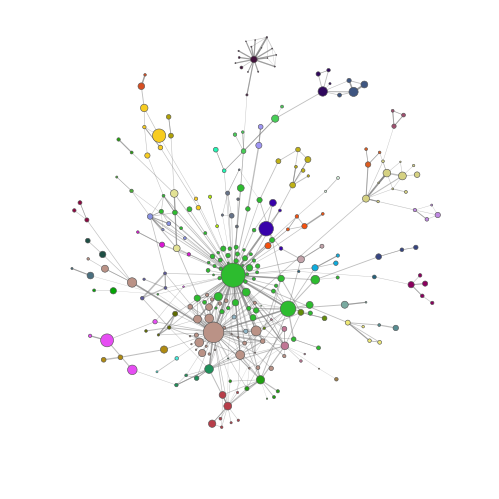

In [28]:
fig, config = nw.visualize(G)

# Community Groups

In [29]:
node_list = node_list.merge(pd.Series(com_to_assign, name='community'), how='left', left_on='id', right_index=True)

<Axes: ylabel='Frequency'>

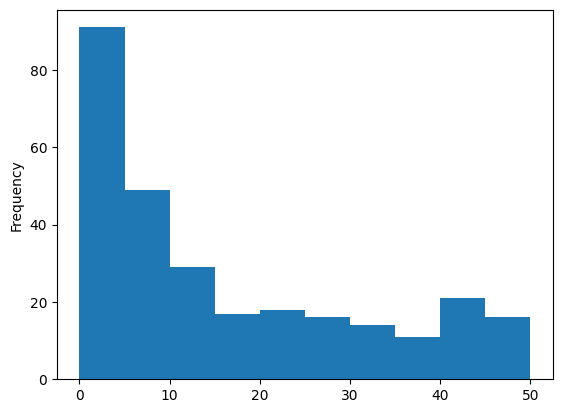

In [30]:
node_list['community'].plot(kind='hist')

In [31]:
node_list.groupby('community')['n_subnodes'].sum().sort_values(ascending=False)


community
4.0     5913
7.0     3654
13.0     941
24.0     836
21.0     804
14.0     688
5.0      555
15.0     476
43.0     412
33.0     358
3.0      342
40.0     334
10.0     301
9.0      298
20.0     297
31.0     281
45.0     280
2.0      274
1.0      218
18.0     204
32.0     193
49.0     186
6.0      185
36.0     182
17.0     176
39.0     174
19.0     171
27.0     167
0.0      151
42.0     146
11.0     145
8.0      144
29.0     141
37.0     140
28.0     135
41.0     131
46.0     130
35.0     129
26.0     120
23.0     109
34.0     106
44.0     104
12.0     101
22.0      59
47.0      58
38.0      58
50.0      50
25.0      48
16.0      45
30.0      41
48.0      37
Name: n_subnodes, dtype: int64

In [32]:
TOP_N = 30

top_comms =node_list.groupby('community')['n_subnodes'].sum().sort_values(ascending=False).head(TOP_N).index.tolist()


In [33]:
node_list

,id,n_subnodes,community
0,nba,142,0.0
1,askreddit,1667,4.0
2,nofap,80,28.0
3,mushroomkingdom,43,NaN
4,subredditdrama,1199,7.0
...,...,...,...
337,modsupport,66,31.0
338,wearethemusicmakers,57,32.0
339,catholicism,23,45.0
340,askfeminists,12,50.0


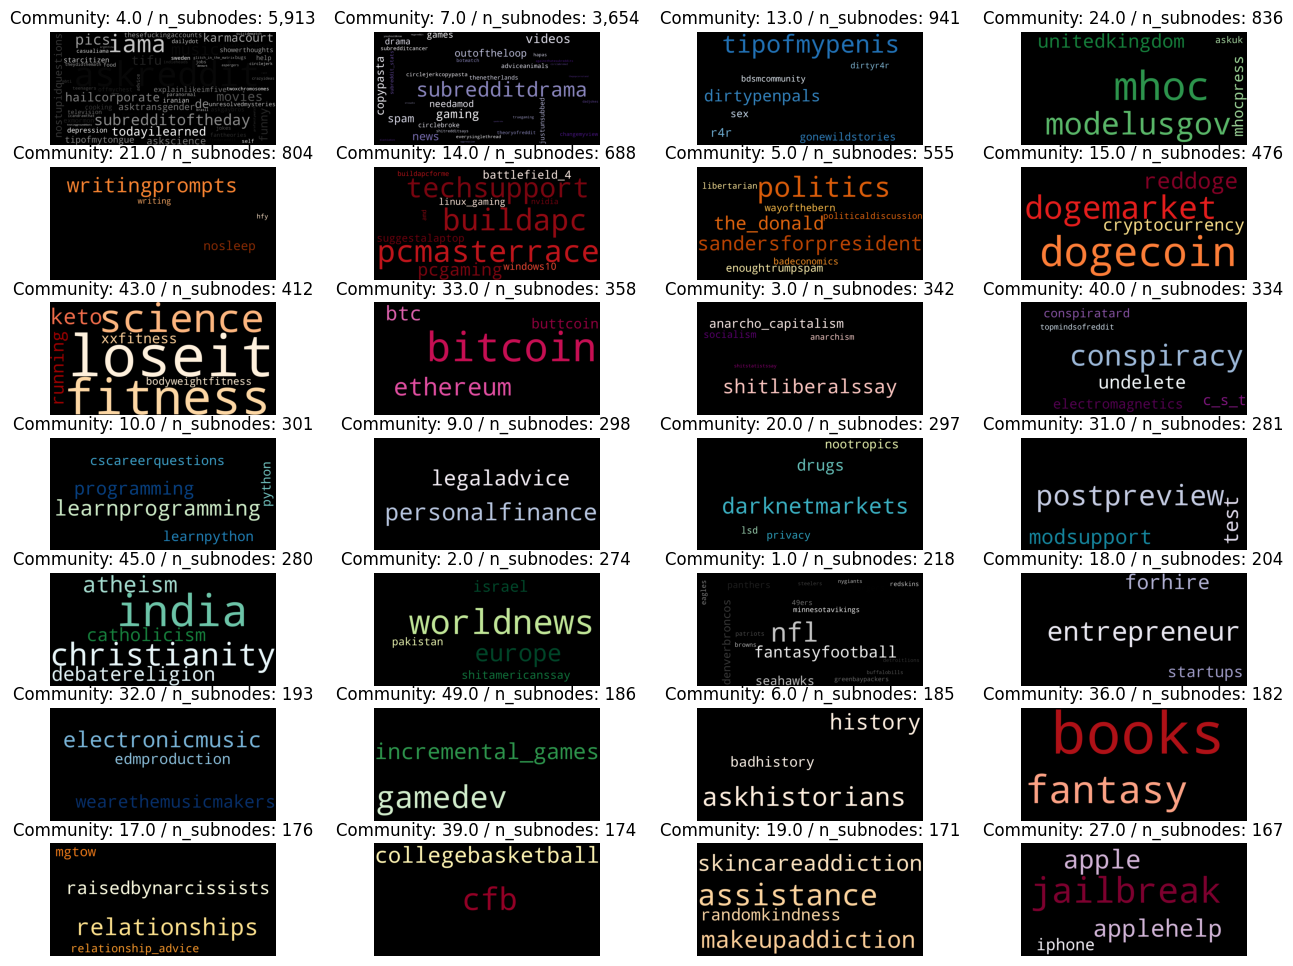

In [34]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig, axes = plt.subplots(int(TOP_N/4),4, figsize=(16,12))
axes = axes.flat

colours = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                          'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                          'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

counts = node_list.groupby('community')['n_subnodes'].sum()

from itertools import cycle
for community, cmap, ax in zip(top_comms, cycle(colours), axes):
    subset = node_list.query(f'community == {community}')
    scores = subset.set_index('id')['n_subnodes'].to_dict()
    wc = WordCloud(colormap=cmap,
                       width=2048,height=1024,
                       background_color='black').generate_from_frequencies(scores)
    ax.imshow(wc)
    ax.axis('off')
    ax.title.set_text(f'Community: {community} / n_subnodes: {counts.loc[community]:,}')

